In [7]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

In [8]:
def random_walk(N, sigma=1, start=0):
    """
    Generates an array representing a random walk for N entries.

    Parameters:
        N (int): The number of entries in the random walk.
        sigma (float, optional): The standard deviation of the random shocks. Default is 1.
        start (float, optional): The starting value of the random walk. Default is 0.

    Returns:
        np.array: An array representing the random walk.
    """
    # Initialize the random walk array with the starting value
    walk = np.zeros(N)
    walk[0] = start

    # Generate the random shocks and accumulate the random walk
    for i in range(1, N):
        shock = np.random.normal(loc=0, scale=sigma)
        walk[i] = walk[i-1] + shock

    return walk

In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(time_series, significance_level=0.05):
    """
    Tests the stationarity of a time series using the Augmented Dickey-Fuller (ADF) test.

    Parameters:
        time_series (np.array or pd.Series): The time series to test.
        significance_level (float, optional): The significance level for the test. Default is 0.05.

    Returns:
        dict: A dictionary containing the ADF test results.
    """
    # Perform the ADF test
    adf_result = adfuller(time_series)

    # Extract the relevant test statistics
    test_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]

    # Determine if the time series is stationary based on the test statistics
    is_stationary = p_value < significance_level and test_statistic < critical_values['1%']

    # Create a dictionary containing the ADF test results
    results = {
        'test_statistic': test_statistic,
        'p_value': p_value,
        'critical_values': critical_values,
        'is_stationary': is_stationary
    }

    return results

In [10]:
walk = random_walk(1000, sigma=1)
results = test_stationarity(walk)
print(results)

{'test_statistic': -1.597631672924684, 'p_value': 0.48478306150085604, 'critical_values': {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 'is_stationary': False}


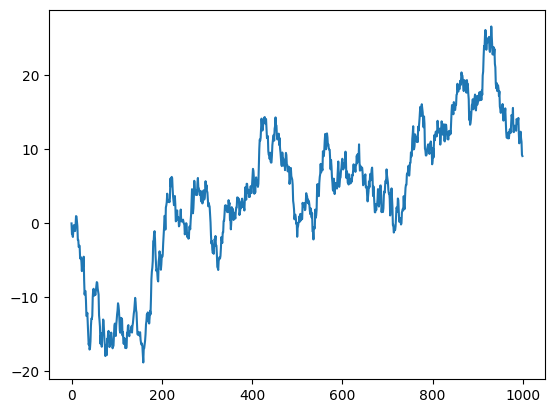

In [12]:
plt.plot(walk)
plt.show()

In [36]:
import numpy as np

def random_walk_with_drift(N, sigma=1, start=0, mu=0, alpha=0.1):
    """
    Generates an array representing a random walk with drift for N entries.

    Parameters:
        N (int): The number of entries in the random walk.
        sigma (float, optional): The standard deviation of the random shocks. Default is 1.
        start (float, optional): The starting value of the random walk. Default is 0.
        mu (float, optional): The mean of the random walk. Default is 0.
        alpha (float, optional): The strength of the mean-reversion. Default is 0.1.

    Returns:
        np.array: An array representing the random walk with drift.
    """
    # Initialize the random walk array with the starting value
    walk = np.zeros(N)
    walk[0] = start

    # Generate the random shocks and accumulate the random walk
    for i in range(1, N):
        shock = np.random.normal(loc=0, scale=sigma)
        drift = alpha * (mu - walk[i-1])
        walk[i] = walk[i-1] + shock + drift

    return walk


In [37]:
walk = random_walk_with_drift(1000, mu=0, alpha=0.1)
results = test_stationarity(walk)
print(results)

{'test_statistic': -7.064898128530715, 'p_value': 5.110548519258393e-10, 'critical_values': {'1%': -3.4369127451400474, '5%': -2.864437475834273, '10%': -2.568312754566378}, 'is_stationary': True}


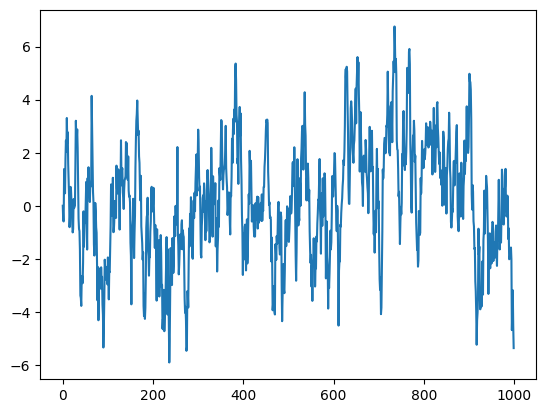

In [38]:
plt.plot(walk)

Attempting to create a trading strategy that has a gaussian profit curve.

In [ ]:
def trade_randomly(prices):

    pnl = [0]

    for i in range(1, len(prices)):
        signal = np.random.choice([-1, 1])
        pnl.append(signal * (prices[i] - prices[i-1]))

In [42]:
def generate_trading_strategy(prices):
    """
    Generates a trading strategy that buys or sells a single stock at random.

    Parameters:
        prices (list): A list of prices of the stock to be traded.

    Returns:
        list: A list representing the profit/loss of the trading strategy.
    """
    # Initialize the profit/loss array with zero
    pnl = [0]

    # Generate random buy/sell signals and update the profit/loss
    for i in range(1, len(prices)):
        signal = np.random.choice([-1, 1])
        pnl.append(signal * (prices[i] - prices[i-1]))

    return pnl


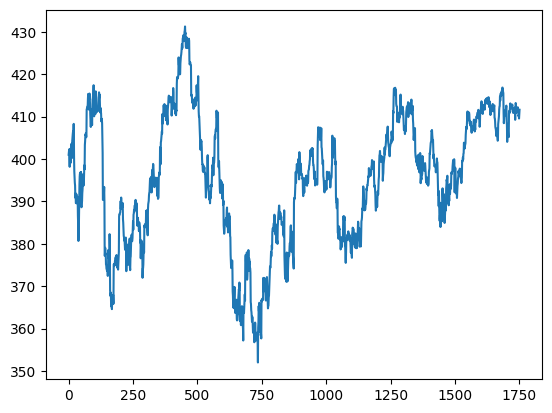

In [49]:
# Get a list of historical daily prices for SPY with yfinance
spy = yf.Ticker('SPY')
spy_history = spy.history(period='1y', interval='60m')
spy_prices = spy_history['Close'].values
plt.plot(spy_prices)

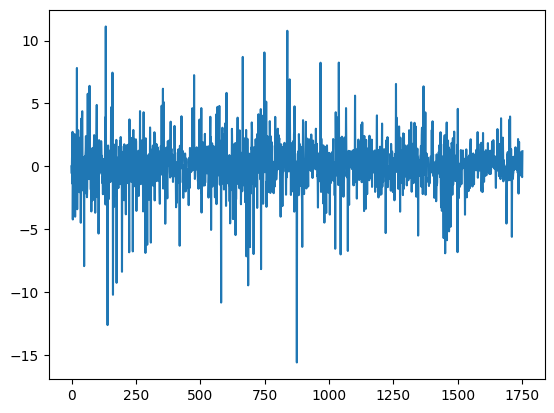

In [50]:
# Trade spy randomly
spy_pnl = generate_trading_strategy(spy_prices)
plt.plot(spy_pnl)

In [51]:
# Test if the above strategy is stationary using the above method
results = test_stationarity(spy_pnl)
print(results)

{'test_statistic': -41.1617337496674, 'p_value': 0.0, 'critical_values': {'1%': -3.434090098474972, '5%': -2.8631920451777195, '10%': -2.5676494998436072}, 'is_stationary': True}


In [60]:
def gaussian_reversion_strategy(prices, S):
    """
    Generates a trading strategy that buys or sells a single stock at random.

    Parameters:
        prices (list): A list of prices of the stock to be traded.

    Returns:
        tuple: A tuple of two lists representing the profit/loss of the random strategy and the mean reversion strategy.
    """
    # Initialize the profit/loss arrays with zero
    pnl_random = [0]
    pnl_mean_reversion = [0]

    # Initialize the variables used for mean reversion
    mean = 0
    std = 0
    position = 0

    # Generate random buy/sell signals and update the profit/loss
    for i in range(1, len(prices)):
        signal = np.random.choice([-1, 1])
        pnl_random.append(signal * (prices[i] - prices[i-1]))

        # Update the mean and standard deviation
        mean = np.mean(pnl_random)
        std = np.std(pnl_random)

        # Check if the pnl is S standard deviations away from the mean
        if abs(pnl_random[-1] - mean) > S * std:
            # If it is, take the same position as the random strategy
            position = signal
        else:
            # If it's not, close the position
            position = 0

        # Add the position to the pnl
        pnl_mean_reversion.append(position * (prices[i] - prices[i-1]))

    return pnl_random, pnl_mean_reversion


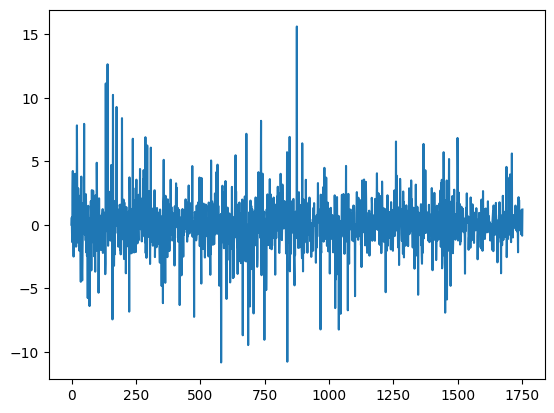

In [63]:
# Trade spy randomly but with mean reversion
pnl_random, pnl_mr = gaussian_reversion_strategy(spy_prices, 2)
plt.plot(pnl_random)

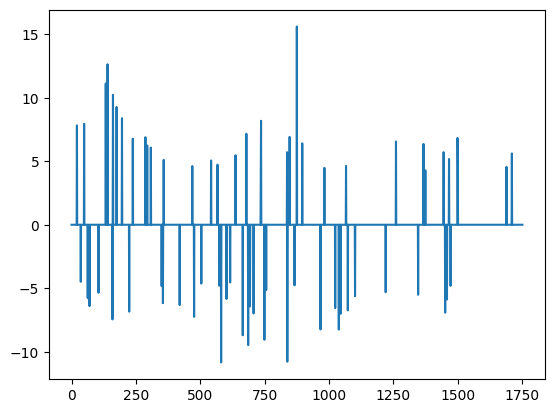

In [64]:
plt.plot(pnl_mr)

In [73]:
import numpy as np

# Generate mock data for the stock prices
np.random.seed(123)
prices = np.cumprod(1 + np.random.normal(0, 0.01, size=1000))

# Define the parameters for the strategy
S = 1.5  # number of standard deviations from the mean to take a position
start = 100  # start trading after this many time points
trade_size = 10  # size of each trade

# Define the function to calculate the returns of the random strategy
def random_strategy(prices):
    pnl = [0]
    for i in range(1, len(prices)):
        trade = np.random.choice([-1, 1], size=1)[0] * trade_size
        pnl.append(trade * (prices[i] - prices[i-1]))
    return pnl

# Define the function to calculate the returns of the mean reversion strategy
def mean_reversion_strategy(prices, S):
    pnl = [0]
    positions = [0]
    for i in range(1, len(prices)):
        trade = np.random.choice([-1, 1], size=1)[0] * trade_size
        pnl.append(trade * (prices[i] - prices[i-1]))
        if i >= start:
            mean = np.mean(pnl[start:i])
            std = np.std(pnl[start:i])
            deviation = pnl[i] - mean
            if deviation > S * std:
                positions.append(-1 * trade_size)
            elif deviation < -1 * S * std:
                positions.append(1 * trade_size)
            else:
                positions.append(0)
        else:
            positions.append(0)
    return [p * q for p, q in zip(pnl, positions)]

# Calculate the returns of the random strategy
random_pnl = random_strategy(prices)

# Calculate the returns of the mean reversion strategy
mean_reversion_pnl = mean_reversion_strategy(prices, S)

# Print the total returns of both strategies
print("Random strategy returns: ", sum(random_pnl))
print("Mean reversion strategy returns: ", sum(mean_reversion_pnl))


Random strategy returns:  0.10124524388111866
Mean reversion strategy returns:  -173.67520098999313


/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [74]:
rand = random_strategy(prices)

# Calculate the returns of the mean reversion strategy
mr = mean_reversion_strategy(prices, S)

# Print the total returns of both strategies
print("Random strategy returns: ", sum(rand))
print("Mean reversion strategy returns: ", sum(mr))


Random strategy returns:  2.8695793375329144
Mean reversion strategy returns:  -170.89970591133874


/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


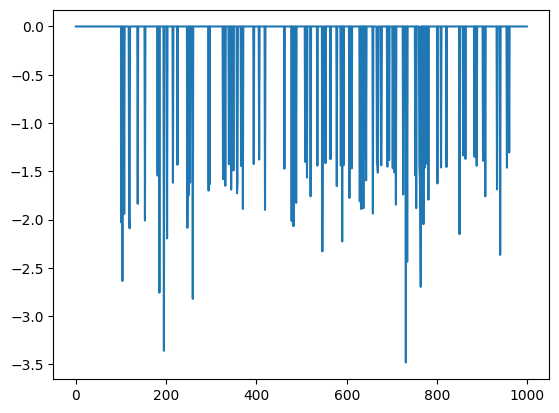

In [77]:
plt.plot(mr)

In [78]:
import numpy as np

# Generate mock data for the stock prices
np.random.seed(123)
prices = np.cumprod(1 + np.random.normal(0, 0.01, size=1000))

# Define the parameters for the strategy
S = 1.5  # number of standard deviations from the mean to take a position
start = 100  # start trading after this many time points
trade_size = 10  # size of each trade

# Define the function to calculate the returns of the random strategy
def random_strategy(prices):
    pnl = [0]
    for i in range(1, len(prices)):
        trade = np.random.choice([-1, 1], size=1)[0] * trade_size
        pnl.append(trade * (prices[i] - prices[i-1]))
    return pnl

# Define the function to calculate the returns of the mean reversion strategy
def mean_reversion_strategy(prices, S):
    pnl = [0]
    positions = [0]
    for i in range(1, len(prices)):
        trade = np.random.choice([-1, 1], size=1)[0] * trade_size
        pnl.append(trade * (prices[i] - prices[i-1]))
        if i >= start:
            mean = np.mean(pnl[start:i])
            std = np.std(pnl[start:i])
            deviation = pnl[i] - mean
            if deviation > S * std:
                positions.append(-1 * trade_size)
            elif deviation < -1 * S * std:
                positions.append(1 * trade_size)
            else:
                positions.append(0)
        else:
            positions.append(0)
    return [p * q for p, q in zip(pnl, positions)]

# Calculate the returns of the random strategy
random_pnl = random_strategy(prices)

# Calculate the returns of the mean reversion strategy
mean_reversion_pnl = mean_reversion_strategy(prices, S)

# Print the total returns of both strategies
print("Random strategy returns: ", sum(random_pnl))
print("Mean reversion strategy returns: ", sum(mean_reversion_pnl))


Random strategy returns:  0.10124524388111866
Mean reversion strategy returns:  -173.67520098999313


/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


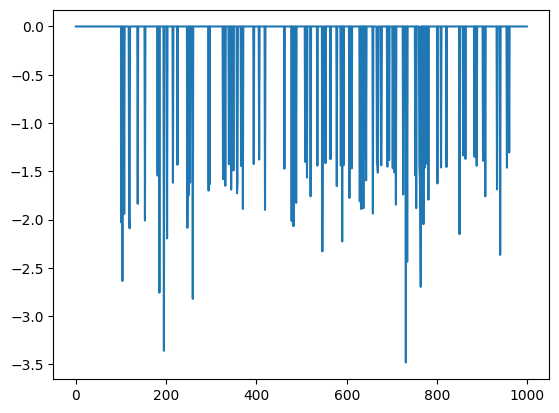

In [83]:
# Plot the random_pnl as a timeseries but only the last ten points
plt.plot(mr)

In [90]:
import numpy as np

# Generate mock data for the stock prices
np.random.seed(101)
prices = np.cumprod(1 + np.random.normal(0, 0.01, size=1000))

# Define the parameters for the strategy
S = 1.5  # number of standard deviations from the mean to take a position
start = 100  # start trading after this many time points
trade_size = 10  # size of each trade

# Define the function to calculate the returns of the random strategy
def random_strategy(prices):
    pnl = [0]
    for i in range(1, len(prices)):
        trade = np.random.choice([-1, 1], size=1)[0] * trade_size
        pnl.append(trade * (prices[i] - prices[i-1]))
    return pnl

# Define the function to calculate the returns of the mean reversion strategy
def mean_reversion_strategy(prices, S):
    pnl = [0]
    positions = [0]
    in_position = False
    for i in range(1, len(prices)):
        trade = np.random.choice([-1, 1], size=1)[0] * trade_size
        pnl.append(trade * (prices[i] - prices[i-1]))
        if i >= start:
            mean = np.mean(pnl[start:i])
            std = np.std(pnl[start:i])
            deviation = pnl[i] - mean
            if deviation > S * std:
                positions.append(-1 * trade_size)
                in_position = True
                entry_mean = mean
                entry_std = std
            elif deviation < -1 * S * std:
                positions.append(1 * trade_size)
                in_position = True
                entry_mean = mean
                entry_std = std
            else:
                positions.append(0)
                in_position = False
            if in_position:
                exit_deviation = pnl[i] - entry_mean
                if (positions[-1] == -1 * trade_size and exit_deviation <= entry_std) or (positions[-1] == 1 * trade_size and exit_deviation >= -1 * entry_std):
                    positions[-1] = 0
                    in_position = False
        else:
            positions.append(0)
            in_position = False
    return [p * q for p, q in zip(pnl, positions)]

# Calculate the returns of the random strategy
random_pnl = random_strategy(prices)

# Calculate the returns of the mean reversion strategy
mean_reversion_pnl = mean_reversion_strategy(prices, S)

# Print the total returns of both strategies
print("Random strategy returns: ", sum(random_pnl))
print("Mean reversion strategy returns: ", sum(mean_reversion_pnl))


Random strategy returns:  3.400192824120447
Mean reversion strategy returns:  -298.82881227727006


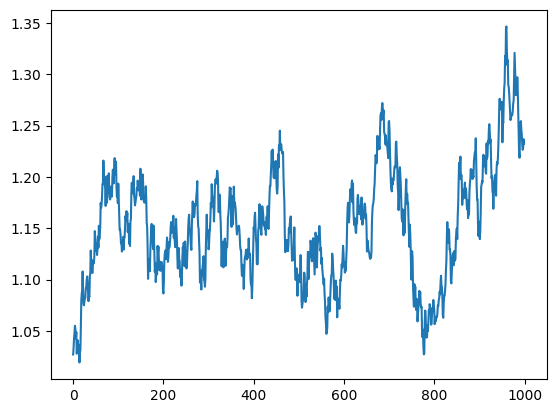

In [91]:
plt.plot(prices)

Random strategy returns:  3.400192824120447
Mean reversion strategy returns:  -298.82881227727006


/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/MilesChild/opt/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


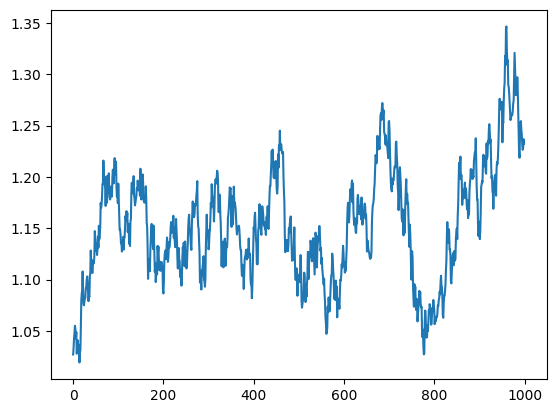

Random strategy returns:  3.400192824120447
Mean reversion strategy returns:  -298.82881227727006


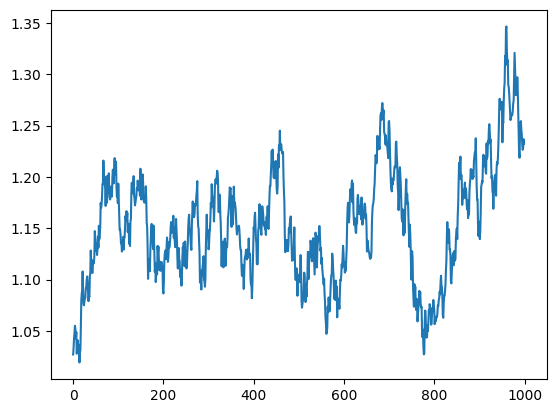

KeyboardInterrupt: 

In [2]:
# Run the above random price generation in an infinite loop, showing the prices as a chart at the end of each loop
import numpy as np
import matplotlib.pyplot as plt
import time

# Define the parameters for the strategy
S = 1.5  # number of standard deviations from the mean to take a position
start = 100  # start trading after this many time points
trade_size = 10  # size of each trade

# Define the function to calculate the returns of the random strategy
def random_strategy(prices):
    pnl = [0]
    for i in range(1, len(prices)):
        trade = np.random.choice([-1, 1], size=1)[0] * trade_size
        pnl.append(trade * (prices[i] - prices[i-1]))
    return pnl

# Define the function to calculate the returns of the mean reversion strategy
def mean_reversion_strategy(prices, S):
    pnl = [0]
    positions = [0]
    in_position = False
    for i in range(1, len(prices)):
        trade = np.random.choice([-1, 1], size=1)[0] * trade_size
        pnl.append(trade * (prices[i] - prices[i-1]))
        if i >= start:
            mean = np.mean(pnl[start:i])
            std = np.std(pnl[start:i])
            deviation = pnl[i] - mean
            if deviation > S * std:
                positions.append(-1 * trade_size)
                in_position = True
                entry_mean = mean
                entry_std = std
            elif deviation < -1 * S * std:
                positions.append(1 * trade_size)
                in_position = True
                entry_mean = mean
                entry_std = std
            else:
                positions.append(0)
                in_position = False
            if in_position:
                exit_deviation = pnl[i] - entry_mean
                if (positions[-1] == -1 * trade_size and exit_deviation <= entry_std) or (positions[-1] == 1 * trade_size and exit_deviation >= -1 * entry_std):
                    positions[-1] = 0
                    in_position = False
        else:
            positions.append(0)
            in_position = False
    return [p * q for p, q in zip(pnl, positions)]

# Run the above random price generation in an infinite loop, showing the prices as a chart at the end of each loop
while True:
    # Generate mock data for the stock prices
    np.random.seed(101)
    prices = np.cumprod(1 + np.random.normal(0, 0.01, size=1000))
    # Calculate the returns of the random strategy
    random_pnl = random_strategy(prices)
    # Calculate the returns of the mean reversion strategy
    mean_reversion_pnl = mean_reversion_strategy(prices, S)
    # Print the total returns of both strategies
    print("Random strategy returns: ", sum(random_pnl))
    print("Mean reversion strategy returns: ", sum(mean_reversion_pnl))
    # Plot the prices
    plt.plot(prices)
    plt.show()
    # Wait for 5 seconds
    time.sleep(5)
    # Clear the plot
    plt.clf()
    

Final profit:  0.777101170034943


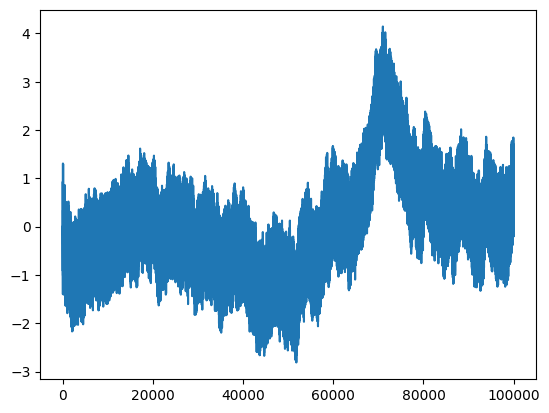

In [27]:
import random
import numpy as np

# Define parameters
N = 100 # number of time steps to use in calculating mean and standard deviation
S = .5 # number of standard deviations from mean to trigger mean reversion

# Initialize profit curve and decision history
profit_curve = [0]
decision_history = []

# Main loop
for i in range(100000):
    # Calculate mean and standard deviation of profit curve over past N time steps
    if len(profit_curve) > N:
        mean = np.mean(profit_curve[-N:])
        std = np.std(profit_curve[-N:])
    else:
        mean = 0
        std = 1
        
    # Make trading decision based on random number
    if random.random() > 0.5:
        decision = 'long'
    else:
        decision = 'short'
    
    # Add decision to history
    decision_history.append(decision)
    
    # Check if mean reversion is needed
    if profit_curve[-1] > mean + S * std:
        decision = 'short'
    elif profit_curve[-1] < mean - S * std:
        decision = 'long'
    
    # Execute trading decision and update profit curve
    if decision == 'long':
        profit_curve.append(profit_curve[-1] + random.uniform(0, 1))
    else:
        profit_curve.append(profit_curve[-1] - random.uniform(0, 1))
        
# Print results
print("Final profit: ", profit_curve[-1])
# Plot profit curve
plt.plot(profit_curve)

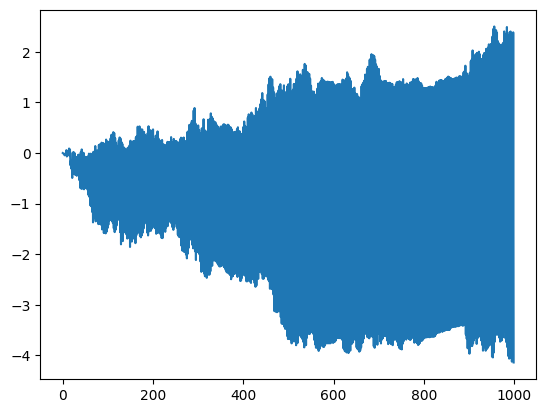

In [33]:
import numpy as np

def random_strategy(price_array):
    # initialize variables
    position = 0  # current position, 1 for long, -1 for short, 0 for neutral
    cash = 0  # current cash balance
    value = 0  # current portfolio value
    pnl = []  # list to store daily profit and loss

    # loop through price array
    for i in range(len(price_array)):
        # generate random decision
        decision = np.random.choice([-1, 1])
        
        # update position and cash based on decision
        if decision == 1 and position < 10:  # buy
            cash -= price_array[i]
            position+= 1
        elif decision == -1 and position > -10:  # sell
            cash += price_array[i]
            position-= 1
        else:  # hold
            pass

        # update portfolio value and pnl
        value = cash + position * price_array[i]
        pnl.append(value - pnl[-1] if pnl else 0)

    return pnl

pnl = random_strategy(prices)
plt.plot(pnl)

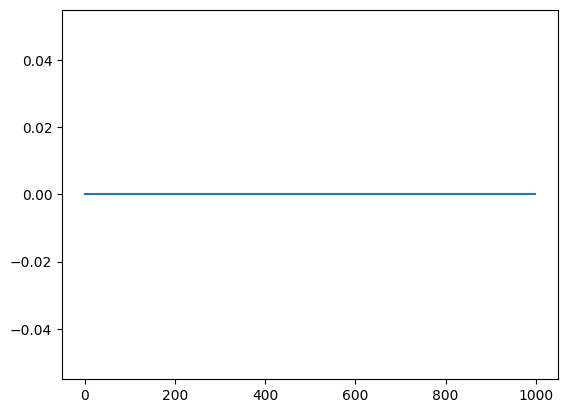

In [35]:
import random
import numpy as np

def random_strategy(price_array):
    position = 0
    pnl = [0] * len(price_array)
    mu = np.mean(price_array)
    sigma = np.std(price_array)
    threshold = 2 * sigma
    for i, price in enumerate(price_array):
        if i == 0:
            continue
        prev_price = price_array[i-1]
        diff = price - prev_price
        if abs(diff) >= threshold:
            position = -1 if diff < 0 else 1
        else:
            position = 0
        pnl[i] = pnl[i-1] + position * (price - prev_price)
    return pnl


pnl=random_strategy(prices)
plt.plot(pnl)

/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_94323/1547866698.py:23: RuntimeWarning: divide by zero encountered in double_scalars
  prob_short = (curr_profit - mean_return) / (4 * std_return)


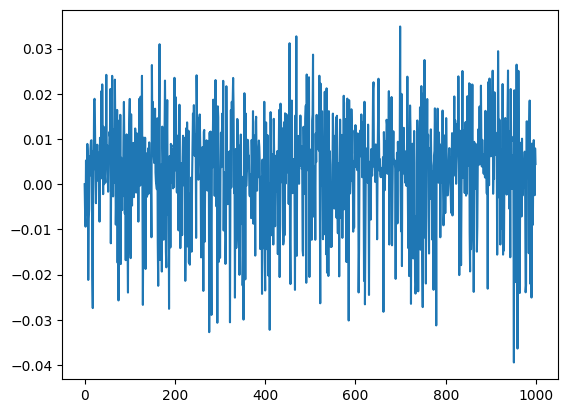

In [40]:
import numpy as np

def random_walk_strategy(prices, num_simulations=1):
    # Initialize variables
    sim_returns = []
    for i in range(num_simulations):
        curr_sim_return = [0]
        curr_position = 0
        mean_return = 0
        
        # Iterate through prices
        for j in range(1, len(prices)):
            # Calculate the current profit
            curr_profit = prices[j] - prices[j-1]
            # Calculate the current mean return
            mean_return = np.mean(curr_sim_return)
            # Calculate the current standard deviation of the returns
            std_return = np.std(curr_sim_return)
            
            # Check if current profit is greater than or less than the mean return
            if curr_profit > mean_return:
                # Calculate the probability of taking a short position
                prob_short = (curr_profit - mean_return) / (2 * std_return)
                # Take a short position with probability prob_short
                if np.random.random() < prob_short:
                    curr_position = -1
                else:
                    curr_position = 1
            else:
                # Calculate the probability of taking a long position
                prob_long = (mean_return - curr_profit) / (2 * std_return)
                # Take a long position with probability prob_long
                if np.random.random() < prob_long:
                    curr_position = 1
                else:
                    curr_position = -1
            
            # Add current position times current profit to simulate trading
            curr_sim_return.append(curr_position * curr_profit)
        
        sim_returns.append(curr_sim_return)
    
    return sim_returns

sim_returns = random_walk_strategy(prices, 1)
plt.plot(sim_returns[0])